In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from pathlib import Path
import seaborn as sns
sns.set_style("white")  # plain white background
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
# =============================================================================
# 1. FIND QUALIFIED FILES
# =============================================================================

def find_bo_csv_files(input_directory, pattern="bo_*results*.csv"):
    """Find all BO CSV files matching pattern in directory"""
    search_path = os.path.join(input_directory, pattern)
    csv_files = glob.glob(search_path)
    
    # Sort by modification time (newest first)
    csv_files.sort(key=os.path.getmtime, reverse=True)
    
    qualified_files = []
    for filepath in csv_files:
        try:
            # Quick validation - check if file has required columns
            df = pd.read_csv(filepath, nrows=5)
            required_cols = ['dataset', 'algorithm', 'iteration', 'best_value', 'regret']
            
            if all(col in df.columns for col in required_cols):
                file_info = {
                    'filepath': filepath,
                    'filename': os.path.basename(filepath),
                    'size_mb': os.path.getsize(filepath) / (1024*1024),
                    'modified': datetime.fromtimestamp(os.path.getmtime(filepath)),
                    'rows': len(pd.read_csv(filepath))
                }
                qualified_files.append(file_info)
            
        except Exception as e:
            print(f"⚠️ Skipping {filepath}: {e}")
    
    return qualified_files

# Configure input directory
INPUT_DIRECTORY = "../results"  # Change this path as needed

print(f"🔍 Searching for BO CSV files in: {INPUT_DIRECTORY}")

if os.path.exists(INPUT_DIRECTORY):
    
    # print all files in the directory
    print("\n📂 Files in directory:"
          , os.listdir(INPUT_DIRECTORY))
    qualified_files = find_bo_csv_files(INPUT_DIRECTORY)
    
    if qualified_files:
        print(f"\n✅ Found {len(qualified_files)} qualified CSV files:")
        print("-" * 60)
        
        for i, file_info in enumerate(qualified_files):
            print(f"{i+1}. {file_info['filename']}")
            print(f"   Size: {file_info['size_mb']:.2f} MB")
            print(f"   Rows: {file_info['rows']:,}")
            print(f"   Modified: {file_info['modified'].strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"   Path: {file_info['filepath']}")
            print()
        
        # Select most recent file for processing
        selected_file = qualified_files[0]
        print(f"🎯 Selected for processing: {selected_file['filename']}")
        
        # Store selected file path globally
        SELECTED_CSV_PATH = selected_file['filepath']
        
    else:
        print("❌ No qualified CSV files found")
        print("   Make sure the directory contains CSV files with columns: algorithm, iteration, best_value, regret")
        SELECTED_CSV_PATH = None
        
else:
    print(f"❌ Directory not found: {INPUT_DIRECTORY}")
    print("   Please update INPUT_DIRECTORY variable above")
    SELECTED_CSV_PATH = None

🔍 Searching for BO CSV files in: ../results

📂 Files in directory: ['bo_results_20250911_215716_500hpa_wide_800hpa_wide_1000hpa_wide_summary.csv', 'bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_800hpa_wide.json', 'bo_results_20250910_215044_500hpa_800hpa_1000hpa_500hpa.json', 'bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_summary.csv', 'bo_results_20250908_231411_youtube_twitch_facebook_enron.csv', 'bo_results_20250908_231411_youtube_twitch_facebook_enron_youtube.json', 'bo_results_20250909_160034_youtube_twitch_facebook_enron_twitch.json', 'bo_results_20250909_160034_youtube_twitch_facebook_enron_facebook.json', 'bo_results_20250911_011626_500hpa_800hpa_1000hpa_800hpa.json', 'bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_1000hpa_wide.json', 'bo_results_20250908_231411_youtube_twitch_facebook_enron_enron.json', 'bo_results_20250911_011626_500hpa_800hpa_1000hpa_summary.csv', 'bo_results_20250911_011626_500hpa_800hpa_1000hpa_1000hpa.j

In [7]:
SELECTED_CSV_PATH = '../results/bo_results_20250909_160034_youtube_twitch_facebook_enron.csv'

In [8]:
# =============================================================================
# 2. (Opt) CONVERT CSV TO JSON
# =============================================================================

def csv_to_json_converter_by_dataset(csv_filepath, output_dir=None):
    """Convert CSV results to structured JSON format, creating one JSON per dataset"""
    if not os.path.exists(csv_filepath):
        raise FileNotFoundError(f"CSV file not found: {csv_filepath}")
    
    print(f"📄 Loading CSV: {os.path.basename(csv_filepath)}")
    df = pd.read_csv(csv_filepath)
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(csv_filepath)
    
    # Check if dataset column exists
    if 'dataset' not in df.columns:
        print("⚠️ No 'dataset' column found. Creating single JSON file.")
        datasets = ['all']
        dataset_dfs = {'all': df}
    else:
        datasets = sorted(df['dataset'].unique())
        dataset_dfs = {dataset: df[df['dataset'] == dataset] for dataset in datasets}
    
    print(f"📊 Found {len(datasets)} dataset(s): {datasets}")
    
    created_files = {}
    
    for dataset in datasets:
        dataset_df = dataset_dfs[dataset]
        
        # Generate JSON filepath for this dataset
        base_name = os.path.splitext(os.path.basename(csv_filepath))[0]
        if dataset != 'all':
            json_filename = f"{base_name}_{dataset}.json"
        else:
            json_filename = f"{base_name}.json"
        json_filepath = os.path.join(output_dir, json_filename)
        
        # Check if JSON file already exists
        if os.path.exists(json_filepath):
            print(f"📄 JSON file already exists for {dataset}: {os.path.basename(json_filepath)}")
            print(f"   Skipping conversion to avoid overwriting")
            
            # Load existing metadata for return
            with open(json_filepath, 'r') as f:
                existing_data = json.load(f)
            metadata = existing_data.get('metadata', {})
            created_files[dataset] = {'filepath': json_filepath, 'metadata': metadata}
            continue
        
        # Extract metadata from DataFrame
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'source_csv': os.path.basename(csv_filepath),
            'dataset': dataset,
            'total_experiments': len(dataset_df),
            'algorithms': sorted(dataset_df['algorithm'].unique().tolist()) if 'algorithm' in dataset_df.columns else [],
            'bo_seeds': sorted(dataset_df['bo_seed'].unique().tolist()) if 'bo_seed' in dataset_df.columns else [],
            'num_bo_runs': len(dataset_df['bo_seed'].unique()) if 'bo_seed' in dataset_df.columns else 0,
            'ground_truth_best': float(dataset_df['ground_truth_best'].iloc[0]) if 'ground_truth_best' in dataset_df.columns and len(dataset_df) > 0 else None,
            'n_nodes': int(dataset_df['n_nodes'].iloc[0]) if 'n_nodes' in dataset_df.columns and len(dataset_df) > 0 else None,
            'max_iterations': int(dataset_df['iteration'].max()) if 'iteration' in dataset_df.columns else None,
            'columns': list(dataset_df.columns)
        }
        
        # Convert DataFrame to JSON-serializable format
        results_data = {
            'metadata': metadata,
            'results': dataset_df.to_dict('records')
        }
        
        # Save JSON file
        with open(json_filepath, 'w') as f:
            json.dump(results_data, f, indent=2)
        
        print(f"✅ JSON saved for {dataset}: {os.path.basename(json_filepath)}")
        print(f"   Total experiments: {metadata['total_experiments']}")
        print(f"   Algorithms: {metadata['algorithms']}")
        print(f"   BO runs: {metadata['num_bo_runs']}")
        print(f"   Graph size: {metadata['n_nodes']} nodes")
        print(f"   Max iterations: {metadata['max_iterations']}")
        print()
        
        created_files[dataset] = {'filepath': json_filepath, 'metadata': metadata}
    
    return created_files

# Convert CSV to JSON by dataset if file was selected
if 'SELECTED_CSV_PATH' in globals() and SELECTED_CSV_PATH:
    try:
        created_files = csv_to_json_converter_by_dataset(SELECTED_CSV_PATH)
        print(f"\n🎉 Conversion completed successfully!")
        
        # Store JSON paths for next step
        CONVERTED_JSON_FILES = created_files
        
    except Exception as e:
        print(f"❌ Conversion failed: {e}")
        CONVERTED_JSON_FILES = {}
        
else:
    print("⚠️ No CSV file selected. Please run the previous cell first.")
    CONVERTED_JSON_FILES = {}

📄 Loading CSV: bo_results_20250909_160034_youtube_twitch_facebook_enron.csv
📊 Found 4 dataset(s): ['enron', 'facebook', 'twitch', 'youtube']
📄 JSON file already exists for enron: bo_results_20250909_160034_youtube_twitch_facebook_enron_enron.json
   Skipping conversion to avoid overwriting
📄 JSON file already exists for facebook: bo_results_20250909_160034_youtube_twitch_facebook_enron_facebook.json
   Skipping conversion to avoid overwriting
📄 JSON file already exists for twitch: bo_results_20250909_160034_youtube_twitch_facebook_enron_twitch.json
   Skipping conversion to avoid overwriting
📄 JSON file already exists for youtube: bo_results_20250909_160034_youtube_twitch_facebook_enron_youtube.json
   Skipping conversion to avoid overwriting

🎉 Conversion completed successfully!


In [9]:
# # =============================================================================
# # 3. LOAD JSON AND VISUALIZE BY DATASET
# # =============================================================================

def load_json_results(json_filepath):
    """Load results from JSON file and return DataFrame + metadata"""
    if not os.path.exists(json_filepath):
        raise FileNotFoundError(f"JSON file not found: {json_filepath}")
    
    print(f"📊 Loading JSON: {os.path.basename(json_filepath)}")
    
    with open(json_filepath, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data['summary_results']) if 'summary_results' in data else pd.DataFrame(data['results'])
    metadata = data['metadata']
    
    print(f"   Loaded {len(df)} experiments")
    print(f"   Algorithms: {metadata.get('algorithms', [])}")
    print(f"   BO runs: {metadata.get('num_bo_runs', 0)}")
    
    return df, metadata

In [13]:
def create_regret_only_plot_for_dataset(
    df,
    metadata,
    figsize=(3.35, 3.2),          # single-column friendly
    legend_loc="upper right",      # keep inside by default
    show_bands=True,
    logx=False
):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator, NullFormatter, LogLocator
    from matplotlib.colors import to_hex
    import seaborn as sns

    # ---- global styling ----
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "font.size": 10,
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "grid.alpha": 0.3,
    })

    # ---- figure ----
    fig, ax = plt.subplots(figsize=figsize)

    # palette
    palette = sns.color_palette("colorblind", n_colors=5)
    colors = {
        "sparse_grf": to_hex(palette[0]),        # blue-ish
        "random_search": to_hex(palette[1]),     # orange-ish
        "bfs": to_hex(palette[2]),               # green-ish
        "dfs": to_hex(palette[3]),               # red-ish
        "thompson_sampling": to_hex(palette[4])  # purple-ish
    }

    legend_names = {
        "random_search": "Random Search",
        "sparse_grf": "GRFs",
        "bfs": "BFS",
        "dfs": "DFS",
        "thompson_sampling": "Thompson Sampling"
    }

    markers = {
        "random_search": "o",
        "sparse_grf": "s",
        "bfs": "^",
        "dfs": "v",
        "thompson_sampling": "D"
    }

    lw, ms, mew = 2.5, 5.5, 1.0

    # algorithms present
    present = [a for a in df["algorithm"].unique()]

    # enforce order: BFS -> DFS -> Random Search -> GRF; others (e.g., TS) follow
    priority = {"bfs": 0, "dfs": 1, "random_search": 2, "sparse_grf": 3}
    algorithms = sorted(
        present,
        key=lambda a: (priority.get(a, 999), a)
    )

    have_seeds = "bo_seed" in df.columns
    n_seeds = df["bo_seed"].nunique() if have_seeds else 1

    # plot each algorithm in desired order
    for algo in algorithms:
        d = df[df["algorithm"] == algo]
        if "iteration" not in d.columns or "regret" not in d.columns:
            continue

        g = d.groupby("iteration")["regret"]
        mean = g.mean().sort_index()
        std = g.std().sort_index()

        color = colors.get(algo, "#000000")
        label = legend_names.get(algo, algo.replace("_", " ").title())
        marker = markers.get(algo, "o")

        ax.plot(
            mean.index.values, mean.values,
            linestyle="-", linewidth=lw,
            color=color, label=label
        )

        if show_bands and n_seeds > 1 and not std.isna().all():
            ax.fill_between(
                mean.index.values,
                (mean - std).values,
                (mean + std).values,
                color=color, alpha=0.2, linewidth=0
            )

    # Add dataset name to title
    dataset_name = metadata.get('dataset', 'Unknown Dataset')

    # labels
    ax.set_xlabel("BO iteration")
    ax.set_ylabel("Regret")

    # x scale & ticks
    if logx:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 10), numticks=12))
        ax.xaxis.set_minor_formatter(NullFormatter())
    else:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune=None))

    # grid
    ax.grid(True, which="major", axis="both")

    # tidy spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # legend (now follows plotting order: BFS -> Random Search -> GRF -> others)
    leg = ax.legend(
        loc=legend_loc,
        frameon=True, framealpha=0.9, fancybox=True, borderpad=0.3
    )
    leg.get_frame().set_linewidth(0.6)

    # margins & x-lim (keep your prior choice)
    ax.margins(x=0.12, y=0.08)
    ax.set_xlim(0,50)
    ax.set_ylim(bottom=-0.01)

    plt.tight_layout(pad=1.5)
    plt.show()
    return fig, ax

def create_regret_plots_for_all_datasets(converted_json_files):
    """Create regret plots for all datasets"""
    if not converted_json_files:
        print("❌ No JSON files to visualize. Please run the conversion step first.")
        return
    
    print(f"📈 Creating regret plots for {len(converted_json_files)} datasets...")
    
    for dataset_name, file_info in converted_json_files.items():
        json_filepath = file_info['filepath']
        
        try:
            print(f"\n📊 Creating regret plot for: {dataset_name}")
            
            # Load data
            df, metadata = load_json_results(json_filepath)
            
            # Create regret plot
            sns.set_style("white")  # plain white background
            regret_fig, regret_ax = create_regret_only_plot_for_dataset(df, metadata)
            
        except Exception as e:
            print(f"❌ Failed to create regret plot for {dataset_name}: {e}")
            continue


📈 Creating journal-style regret plots for all datasets...
📈 Creating regret plots for 4 datasets...

📊 Creating regret plot for: enron
📊 Loading JSON: bo_results_20250909_160034_youtube_twitch_facebook_enron_enron.json
   Loaded 4000 experiments
   Algorithms: ['bfs', 'dfs', 'random_search', 'sparse_grf']
   BO runs: 10


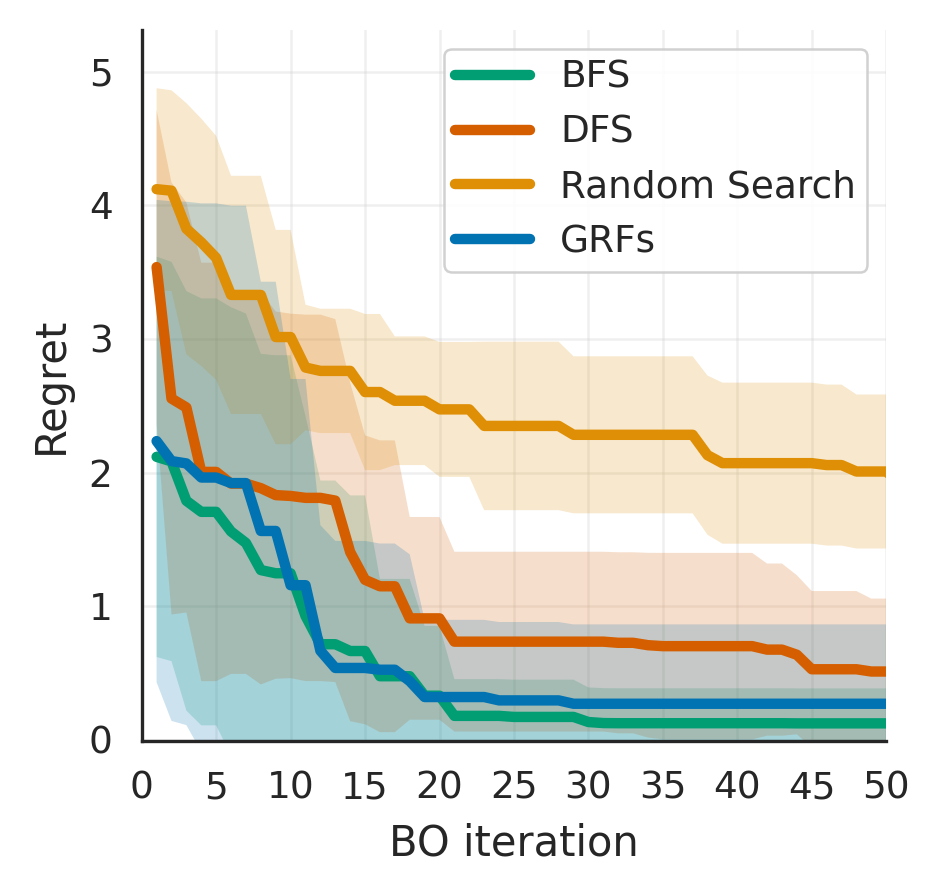


📊 Creating regret plot for: facebook
📊 Loading JSON: bo_results_20250909_160034_youtube_twitch_facebook_enron_facebook.json
   Loaded 4000 experiments
   Algorithms: ['bfs', 'dfs', 'random_search', 'sparse_grf']
   BO runs: 10


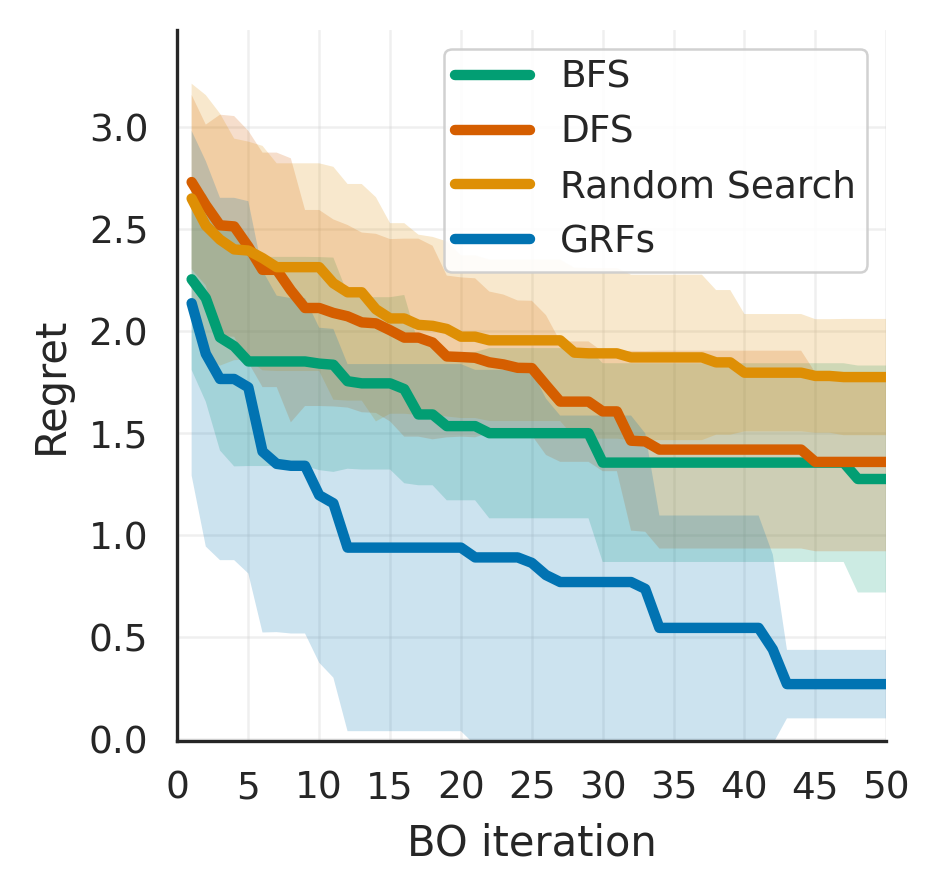


📊 Creating regret plot for: twitch
📊 Loading JSON: bo_results_20250909_160034_youtube_twitch_facebook_enron_twitch.json
   Loaded 4000 experiments
   Algorithms: ['bfs', 'dfs', 'random_search', 'sparse_grf']
   BO runs: 10


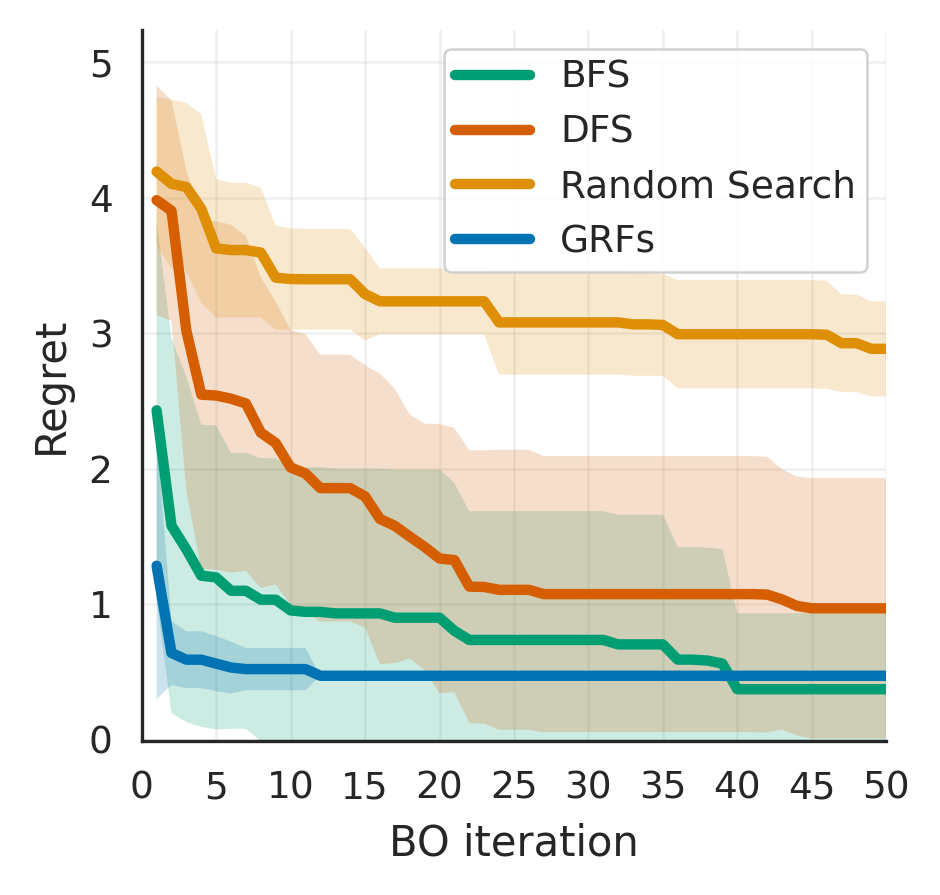


📊 Creating regret plot for: youtube
📊 Loading JSON: bo_results_20250909_160034_youtube_twitch_facebook_enron_youtube.json
   Loaded 4000 experiments
   Algorithms: ['bfs', 'dfs', 'random_search', 'sparse_grf']
   BO runs: 10


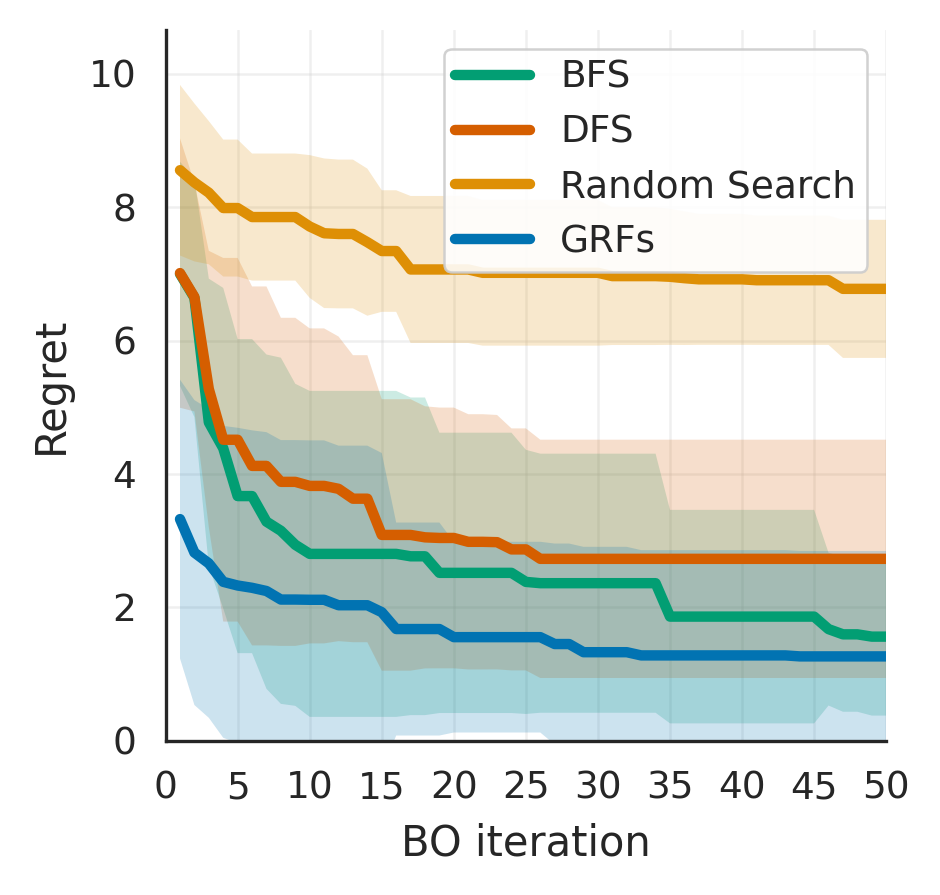

In [14]:
sns.set_style("white")  # plain white background
if 'CONVERTED_JSON_FILES' in globals() and CONVERTED_JSON_FILES:
    print("📈 Creating journal-style regret plots for all datasets...")
    create_regret_plots_for_all_datasets(CONVERTED_JSON_FILES)
else:
    print("❌ No converted JSON files found. Please run the previous cells first.")
